In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transform
import cv2
from  torch.cuda.amp import autocast, GradScaler
from copy import deepcopy
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
from matplotlib import patheffects as pe
import sys
import os
from tqdm import tqdm, trange
py_file_location = "/content/drive/My Drive/Image Super Resolution/SRCNN/"
sys.path.append(os.path.abspath(py_file_location))
from dataset import DIV2KDataset
from model import SRCNN, DRRN
from loss import PixelL1Loss, PixelL2Loss, ContentLoss
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_dataset = DIV2KDataset(0)
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle=True, num_workers=2, pin_memory=True)

valid_dataset = DIV2KDataset(1)
valid_dataloader = DataLoader(valid_dataset,batch_size = 1, shuffle=False, num_workers=2, pin_memory=True)


test_dataset = DIV2KDataset(2)
test_dataloader = DataLoader(test_dataset,batch_size = 1, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
def train(model, train_loader, valid_loader,loss, epochs=50, resume=False, save=False):
  store_model = '/content/drive/My Drive/Image Super Resolution/SRCNN/Model_Parameters/'
  out_img_path = '/content/drive/My Drive/Image Super Resolution/SRCNN/Valid Output/RModel5/'
  cudnn.benchmark = True
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model
  loss_list = list()
  psnr_list = list()
  ssim_list = list()
  val_loss_list = list()
  val_psnr_list = list()
  val_ssim_list = list()
  lr_list = list()
  mssim = 0
  epoch_loss = 0
  epoch_psnr = 0
  epoch_ssim = 0
  val_loss = 0
  val_psnr = 0
  val_ssim = 0
  if loss == 'L1':
    criterion = PixelL1Loss()
    criterion.to(device)
  if loss == 'L2':
    criterion = PixelL2Loss()
    criterion.to(device)
  elif loss == 'Content':
    criterion = ContentLoss()
    criterion.to(device)

  mse = PixelL2Loss()
  mse = mse.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=7e-3, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=7e-5, max_lr=7e-3)
  scaler = GradScaler()

  if resume:
    checkpoint = torch.load(os.path.join(store_model, "Rmodel5.pth.tar"))
    model.load_state_dict(deepcopy(checkpoint['model']))
    optimizer.load_state_dict(deepcopy(checkpoint['optimizer']))
    scheduler.load_state_dict(deepcopy(checkpoint['scheduler']))
    ep = deepcopy(checkpoint['epoch'])
    loss_list = deepcopy(checkpoint['Train_Loss'])
    psnr_list = deepcopy(checkpoint['Train_PSNR'])
    val_loss_list = deepcopy(checkpoint['Valid_Loss'])
    val_psnr_list = deepcopy(checkpoint['Valid_PSNR'])
    lr_list = deepcopy(checkpoint['lr'])
  else: 
    ep = 0

  for epoch in range(ep, epochs):
    mssim = 0
    epoch_loss = 0
    epoch_psnr = 0
    epoch_ssim = 0
    val_loss = 0
    val_psnr = 0
    val_ssim = 0
    
    # Model Se to Train for tarining
    model.train()

    with tqdm(train_loader, unit='batch') as tepoch:
      tepoch.set_description(f"Epoch {epoch+1:4d}/{epochs}")
      for i, (LR, HR, im1, im2) in enumerate(tepoch):
        LR, HR = LR.to(device), HR.to(device)
        
        
        # Mixed Precision Training
        with autocast():
          # Forward Propagation
          SR = model(LR)

          # Computing Loss
          loss = criterion(SR, HR)
          optimizer.zero_grad(set_to_none=True)

          # Backward Propagation
          scaler.scale(loss).backward()
          # loss.backward()
          epoch_loss += loss.item() / len(train_dataloader)

          # Update Weights
          scaler.step(optimizer)
          # optimizer.step()
          scaler.update()

          epoch_psnr += (10. * torch.log10(1. / mse(SR, HR))).cpu().detach().numpy() / len(train_dataloader)
        tepoch.set_postfix(TrainLOSS = epoch_loss, TrainPSNR = epoch_psnr)

      loss_list.append(epoch_loss)
      psnr_list.append(epoch_psnr)
      lr_list.append(deepcopy(scheduler.get_last_lr()))
      # Adjust Learning Rate After Each Epoch
      scheduler.step()
      
      # Validation
      with torch.no_grad():
        val_psnr = 0
        model.eval()
        with tqdm(valid_loader, unit='images') as validation:
          validation.set_description("Validation")
          for i, (LR, HR, im1, im2) in enumerate(validation):
            LR, HR = LR.to(device), HR.to(device)
            with autocast():
              SR = model(LR).clamp(0.0, 1.0)
              loss = criterion(SR, HR)
              val_loss += loss.item() / len(valid_loader)
              # val_psnr += (10. * torch.log10(1. / ps(SR, HR))).cpu().detach().numpy() / len(valid_loader)
            SR = SR.cpu().detach().numpy()
            HR = HR.cpu().detach().numpy()
            val_psnr += psnr(SR, HR) / len(valid_loader)
            im1 = im1.cpu().detach().numpy()
            im1 = (im1[0]).transpose((1, 2, 0))
            im1[:, :, 0] = SR[0][0] * 255.0
            im1 = np.uint8(im1)
            im1 = cv2.cvtColor(im1, cv2.COLOR_YCrCb2BGR)
            im2 = im2.cpu().detach().numpy()
            im2 = (im2[0]).transpose((1, 2, 0))
            im2 = np.uint8(im2)
            mssim +=  ssim(im1, im2, data_range=im1.max() - im1.min(), multichannel=True) / len(valid_loader)
            validation.set_postfix(ValidationLoss = val_loss, ValidationPSNR = val_psnr, ValidationSSIM=mssim)
            if save:
              path = os.path.join(out_img_path, f'{i:04d}.png')
              cv2.imwrite(path, im1)
      val_loss_list.append(val_loss)
      val_psnr_list.append(val_psnr)
      torch.cuda.empty_cache()

      torch.save({"epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "Train_Loss": loss_list,
                "Train_PSNR": psnr_list,
                "Valid_Loss": val_loss_list,
                "Valid_PSNR": val_psnr_list,
                "lr": lr_list},
                os.path.join(store_model, "Rmodel5.pth.tar"))
    print('\n')
  return loss_list, psnr_list, val_loss_list, val_psnr_list, lr_list

      
#1hr 35 minutes

In [4]:
def test(model, test_loader, loss, save=True):
  out_img_path = '/content/drive/My Drive/Image Super Resolution/SRCNN/Test Output/RModel2/'
  cudnn.benchmark = True
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model
  if loss == 'L1':
    criterion = PixelL1Loss()
    criterion.to(device)
  if loss == 'L2':
    criterion = PixelL2Loss()
    criterion.to(device)
  elif loss == 'Content':
    criterion = ContentLoss()
    criterion.to(device)
  mse = PixelL2Loss()
  test_psnr = 0
  test_ssim = 0
  test_loss = 0
  # set the model to evaluvation mode
  # For Running the Model on Test Data
      # Validation
  with torch.no_grad():
    model.eval()
    with tqdm(test_loader, unit='images') as Test:
      Test.set_description("Validation")
      for i, (LR, HR, im1, im2) in enumerate(Test):
        LR, HR = LR.to(device), HR.to(device)
        with autocast():
          SR = model(LR).clamp(0.0, 1.0)
          loss = criterion(SR, HR)
          test_loss += loss.item() / len(test_loader)
          # make_dot(SR, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")
          # test_psnr += (10. * torch.log10(1. / mse(SR, HR))).cpu().detach().numpy() / len(test_loader)
        SR = SR.cpu().detach().numpy()
        HR = HR.cpu().detach().numpy()
        # SR = SR.astype(float32)
        # HR = HR.astype(float32)
        test_psnr += psnr(SR, HR) / len(test_loader)
        im1 = im1.cpu().detach().numpy()
        im1 = (im1[0]).transpose((1, 2, 0))
        im1[:, :, 0] = SR[0][0] * 255.0
        im1 = np.uint8(im1)
        im1 = cv2.cvtColor(im1, cv2.COLOR_YCrCb2BGR)
        im2 = im2.cpu().detach().numpy()
        im2 = (im2[0]).transpose((1, 2, 0))
        im2 = np.uint8(im2)
        test_ssim +=  ssim(im1, im2, data_range=im1.max() - im1.min(), multichannel=True) / len(test_loader)
        Test.set_postfix(TestLoss = test_loss, TestPSNR = test_psnr, TestSSIM=test_ssim)
        
        if save:
          path = os.path.join(out_img_path, f'{i:04d}.png')
          cv2.imwrite(path, im1)
  torch.cuda.empty_cache()




In [ ]:
c = 1
f1 = 64
f2 = 32
rmodel1 = SRCNN(c, f1, f2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rmodel1.to(device)
summary(rmodel1, input_size=(1, 512, 512))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           5,248
            Conv2d-2         [-1, 32, 512, 512]          51,232
            Conv2d-3          [-1, 1, 512, 512]             801
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 194.00
Params size (MB): 0.22
Estimated Total Size (MB): 195.22
----------------------------------------------------------------


In [ ]:
trainloss1, trainPSNR1, valloss1, valPSNR1, lr_list = train(model=rmodel1, train_loader=train_dataloader,loss='L2', valid_loader=valid_dataloader, epochs=100, resume=True, save=True)

Validation: 100%|██████████| 200/200 [00:31<00:00,  6.30images/s, ValidationLoss=0.00595, ValidationPSNR=23, ValidationSSIM=0.669]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.28images/s, ValidationLoss=0.00592, ValidationPSNR=23, ValidationSSIM=0.67]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.25images/s, ValidationLoss=0.00589, ValidationPSNR=23.1, ValidationSSIM=0.672]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.29images/s, ValidationLoss=0.00586, ValidationPSNR=23.1, ValidationSSIM=0.673]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.25images/s, ValidationLoss=0.00583, ValidationPSNR=23.1, ValidationSSIM=0.674]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.27images/s, ValidationLoss=0.0058, ValidationPSNR=23.1, ValidationSSIM=0.675]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.19images/s, ValidationLoss=0.00578, ValidationPSNR=23.2, ValidationSSIM=0.676]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.24images/s, ValidationLoss=0.00575, ValidationPSNR=23.2, ValidationSSIM=0.677]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.23images/s, ValidationLoss=0.00573, ValidationPSNR=23.2, ValidationSSIM=0.678]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.20images/s, ValidationLoss=0.0057, ValidationPSNR=23.2, ValidationSSIM=0.679]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.23images/s, ValidationLoss=0.00568, ValidationPSNR=23.2, ValidationSSIM=0.68]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.20images/s, ValidationLoss=0.00566, ValidationPSNR=23.3, ValidationSSIM=0.681]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.24images/s, ValidationLoss=0.00563, ValidationPSNR=23.3, ValidationSSIM=0.682]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.20images/s, ValidationLoss=0.00561, ValidationPSNR=23.3, ValidationSSIM=0.683]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.28images/s, ValidationLoss=0.00559, ValidationPSNR=23.3, ValidationSSIM=0.684]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.19images/s, ValidationLoss=0.00557, ValidationPSNR=23.3, ValidationSSIM=0.684]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.18images/s, ValidationLoss=0.00555, ValidationPSNR=23.4, ValidationSSIM=0.685]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.19images/s, ValidationLoss=0.00553, ValidationPSNR=23.4, ValidationSSIM=0.686]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.24images/s, ValidationLoss=0.00552, ValidationPSNR=23.4, ValidationSSIM=0.687]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.23images/s, ValidationLoss=0.0055, ValidationPSNR=23.4, ValidationSSIM=0.687]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.21images/s, ValidationLoss=0.00548, ValidationPSNR=23.4, ValidationSSIM=0.688]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.23images/s, ValidationLoss=0.00546, ValidationPSNR=23.4, ValidationSSIM=0.688]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.23images/s, ValidationLoss=0.00545, ValidationPSNR=23.4, ValidationSSIM=0.689]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.25images/s, ValidationLoss=0.00543, ValidationPSNR=23.5, ValidationSSIM=0.69]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.22images/s, ValidationLoss=0.00542, ValidationPSNR=23.5, ValidationSSIM=0.69]


Validation: 100%|██████████| 200/200 [00:33<00:00,  6.06images/s, ValidationLoss=0.0054, ValidationPSNR=23.5, ValidationSSIM=0.69]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.21images/s, ValidationLoss=0.00539, ValidationPSNR=23.5, ValidationSSIM=0.69]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.22images/s, ValidationLoss=0.00537, ValidationPSNR=23.5, ValidationSSIM=0.691]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.21images/s, ValidationLoss=0.00536, ValidationPSNR=23.5, ValidationSSIM=0.691]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.20images/s, ValidationLoss=0.00535, ValidationPSNR=23.5, ValidationSSIM=0.692]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.19images/s, ValidationLoss=0.00533, ValidationPSNR=23.6, ValidationSSIM=0.692]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.14images/s, ValidationLoss=0.00532, ValidationPSNR=23.6, ValidationSSIM=0.693]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.18images/s, ValidationLoss=0.00531, ValidationPSNR=23.6, ValidationSSIM=0.693]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.21images/s, ValidationLoss=0.00529, ValidationPSNR=23.6, ValidationSSIM=0.693]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.17images/s, ValidationLoss=0.00528, ValidationPSNR=23.6, ValidationSSIM=0.694]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.15images/s, ValidationLoss=0.00527, ValidationPSNR=23.6, ValidationSSIM=0.694]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.18images/s, ValidationLoss=0.00526, ValidationPSNR=23.6, ValidationSSIM=0.694]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.21images/s, ValidationLoss=0.00524, ValidationPSNR=23.6, ValidationSSIM=0.695]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.17images/s, ValidationLoss=0.00523, ValidationPSNR=23.6, ValidationSSIM=0.695]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.07images/s, ValidationLoss=0.00522, ValidationPSNR=23.7, ValidationSSIM=0.696]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.15images/s, ValidationLoss=0.00521, ValidationPSNR=23.7, ValidationSSIM=0.696]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.19images/s, ValidationLoss=0.0052, ValidationPSNR=23.7, ValidationSSIM=0.696]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.18images/s, ValidationLoss=0.00519, ValidationPSNR=23.7, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.16images/s, ValidationLoss=0.00517, ValidationPSNR=23.7, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.20images/s, ValidationLoss=0.00516, ValidationPSNR=23.7, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.13images/s, ValidationLoss=0.00515, ValidationPSNR=23.7, ValidationSSIM=0.698]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.17images/s, ValidationLoss=0.00514, ValidationPSNR=23.7, ValidationSSIM=0.698]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.20images/s, ValidationLoss=0.00513, ValidationPSNR=23.8, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.18images/s, ValidationLoss=0.00512, ValidationPSNR=23.8, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.15images/s, ValidationLoss=0.00511, ValidationPSNR=23.8, ValidationSSIM=0.698]

In [7]:
store_model = '/content/drive/My Drive/Image Super Resolution/SRCNN/Model_Parameters/'
checkpoint = torch.load(os.path.join(store_model, "Rmodel2.pth.tar"))
rmodel2.load_state_dict(deepcopy(checkpoint['model']))
# optimizer.load_state_dict(deepcopy(checkpoint['optimizer']))
# scheduler.load_state_dict(deepcopy(checkpoint['scheduler']))
# ep = deepcopy(checkpoint['epoch'])
loss_list = deepcopy(checkpoint['Train_Loss'])
psnr_list = deepcopy(checkpoint['Train_PSNR'])
val_loss_list = deepcopy(checkpoint['Valid_Loss'])
val_psnr_list = deepcopy(checkpoint['Valid_PSNR'])
lr_list = deepcopy(checkpoint['lr'])

In [ ]:
test(model=rmodel1, test_loader=test_dataloader,loss='L2',save=True)

Validation: 100%|██████████| 100/100 [00:16<00:00,  6.18images/s, TestLoss=0.00537, TestPSNR=23.5, TestSSIM=0.689]


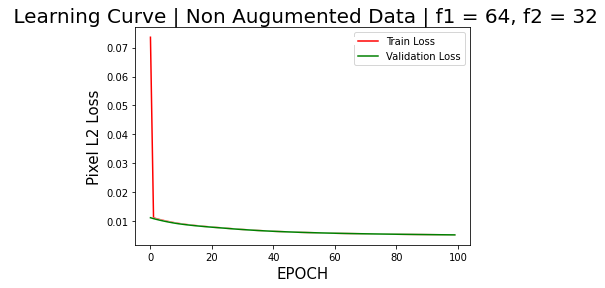

In [ ]:
plt.plot(trainloss1, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valloss1, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("Pixel L2 Loss", size = 15)
plt.title(" Learning Curve | Non Augumented Data | f1 = 64, f2 = 32", size = 20)
plt.savefig("rmodel1.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

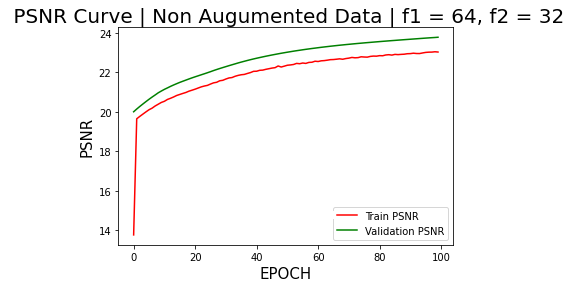

In [ ]:
plt.plot(trainPSNR1, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valPSNR1, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train PSNR','Validation PSNR'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("PSNR", size = 15)
plt.title(" PSNR Curve | Non Augumented Data | f1 = 64, f2 = 32", size = 20)
plt.savefig("rmodel1PSNR.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

In [5]:
c = 1
f1 = 128
f2 = 32
rmodel2 = SRCNN(c, f1, f2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rmodel2.to(device)
summary(rmodel2, input_size=(1, 512, 512))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 512, 512]          10,496
            Conv2d-2         [-1, 32, 512, 512]         102,432
            Conv2d-3          [-1, 1, 512, 512]             801
Total params: 113,729
Trainable params: 113,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 322.00
Params size (MB): 0.43
Estimated Total Size (MB): 323.43
----------------------------------------------------------------


In [ ]:
trainloss2, trainPSNR2, valloss2, valPSNR2, lr_list2 = train(model=rmodel2, train_loader=train_dataloader,loss='L2', valid_loader=valid_dataloader ,
                                                             epochs=100, resume=True, save=True)

Validation: 100%|██████████| 200/200 [01:15<00:00,  2.64images/s, ValidationLoss=0.00488, ValidationPSNR=24, ValidationSSIM=0.707]

In [8]:
test(model=rmodel2, test_loader=test_dataloader,loss='L2',save=True)

Validation: 100%|██████████| 100/100 [00:31<00:00,  3.17images/s, TestLoss=0.00512, TestPSNR=23.8, TestSSIM=0.7]


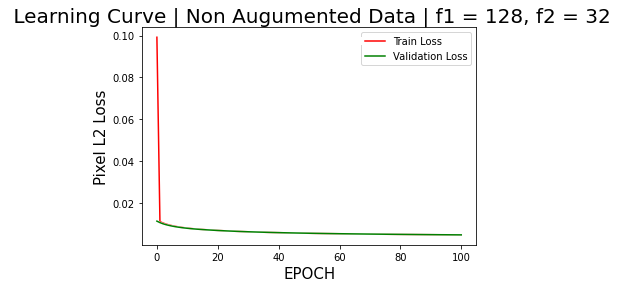

In [ ]:
plt.plot(trainloss2, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valloss2, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("Pixel L2 Loss", size = 15)
plt.title(" Learning Curve | Non Augumented Data | f1 = 128, f2 = 32", size = 20)
plt.savefig("rmodel2.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

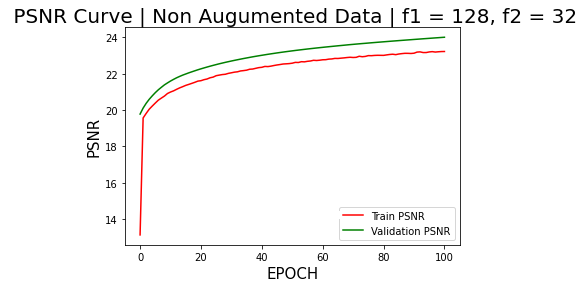

In [ ]:
plt.plot(trainPSNR2, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valPSNR2, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train PSNR','Validation PSNR'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("PSNR", size = 15)
plt.title(" PSNR Curve | Non Augumented Data | f1 = 128, f2 = 32", size = 20)
plt.savefig("rmodel2PSNR.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

In [ ]:
c = 1
f1 = 128
f2 = 64
rmodel3 = SRCNN(c, f1, f2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rmodel3.to(device)
summary(rmodel3, input_size=(1, 512, 512))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 512, 512]          10,496
            Conv2d-2         [-1, 64, 512, 512]         204,864
            Conv2d-3          [-1, 1, 512, 512]           1,601
Total params: 216,961
Trainable params: 216,961
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 386.00
Params size (MB): 0.83
Estimated Total Size (MB): 387.83
----------------------------------------------------------------


In [ ]:
c = 1
f = 128
U = 9
rmodel4 = DRRN(c, f, U)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rmodel4.to(device)
summary(rmodel4, input_size=(1, 512, 512))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 512, 512]               2
              ReLU-2          [-1, 1, 512, 512]               0
            Conv2d-3        [-1, 128, 512, 512]           1,152
         ConvBlock-4        [-1, 128, 512, 512]               0
       BatchNorm2d-5        [-1, 128, 512, 512]             256
              ReLU-6        [-1, 128, 512, 512]               0
            Conv2d-7        [-1, 128, 512, 512]         147,456
         ConvBlock-8        [-1, 128, 512, 512]               0
       BatchNorm2d-9        [-1, 128, 512, 512]             256
             ReLU-10        [-1, 128, 512, 512]               0
           Conv2d-11        [-1, 128, 512, 512]         147,456
        ConvBlock-12        [-1, 128, 512, 512]               0
 ResidualFunction-13        [-1, 128, 512, 512]               0
      BatchNorm2d-14        [-1, 1

In [ ]:
trainloss4, trainPSNR4, valloss4, valPSNR4, lr_list4 = train(model=rmodel4, train_loader=train_dataloader,loss='L2', valid_loader=valid_dataloader, epochs=100, resume=True, save=True)

Validation: 100%|██████████| 200/200 [00:31<00:00,  6.36images/s, ValidationLoss=0.00451, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.21images/s, ValidationLoss=0.00452, ValidationPSNR=24.4, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.30images/s, ValidationLoss=0.0045, ValidationPSNR=24.5, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.0045, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.0045, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.00449, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.31images/s, ValidationLoss=0.0045, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.31images/s, ValidationLoss=0.00448, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.31images/s, ValidationLoss=0.00446, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.27images/s, ValidationLoss=0.00446, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.26images/s, ValidationLoss=0.00447, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.28images/s, ValidationLoss=0.00447, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.29images/s, ValidationLoss=0.00446, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.29images/s, ValidationLoss=0.00446, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.00445, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.28images/s, ValidationLoss=0.00445, ValidationPSNR=24.5, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.31images/s, ValidationLoss=0.00444, ValidationPSNR=24.5, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.30images/s, ValidationLoss=0.00445, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.29images/s, ValidationLoss=0.00444, ValidationPSNR=24.5, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.00443, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.33images/s, ValidationLoss=0.00444, ValidationPSNR=24.6, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.33images/s, ValidationLoss=0.00443, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.25images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.30images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.31images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.32images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.34images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.30images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.36images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.37images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.24images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.24images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.29images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:33<00:00,  6.05images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.36images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.33images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.35images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.40images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.36images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.30images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.38images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.35images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.36images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.37images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.34images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.37images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.34images/s, ValidationLoss=0.00437, ValidationPSNR=24.6, ValidationSSIM=0.72]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.34images/s, ValidationLoss=0.00437, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.31images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


In [ ]:
test(model=rmodel4, test_loader=test_dataloader,loss='L2',save=True)

Validation: 100%|██████████| 100/100 [00:15<00:00,  6.33images/s, TestLoss=0.00462, TestPSNR=24.4, TestSSIM=0.712]


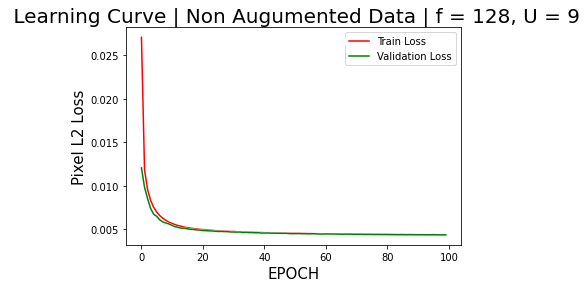

In [ ]:
plt.plot(trainloss4, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valloss4, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("Pixel L2 Loss", size = 15)
plt.title(" Learning Curve | Non Augumented Data | f = 128, U = 9", size = 20)
plt.savefig("rmodel4.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

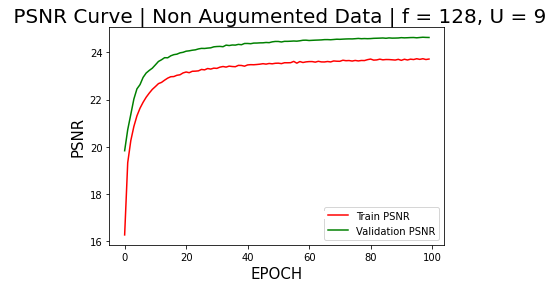

In [ ]:
plt.plot(trainPSNR4, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valPSNR4, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train PSNR','Validation PSNR'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("PSNR", size = 15)
plt.title(" PSNR Curve | Non Augumented Data | f = 128, U = 9", size = 20)
plt.savefig("rmodel4PSNR.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

In [ ]:
c = 1
f = 64
U = 18
rmodel5 = DRRN(c, f, U)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rmodel5.to(device)
summary(rmodel5, input_size=(1, 512, 512))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 512, 512]               2
              ReLU-2          [-1, 1, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]             576
         ConvBlock-4         [-1, 64, 512, 512]               0
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
            Conv2d-7         [-1, 64, 512, 512]          36,864
         ConvBlock-8         [-1, 64, 512, 512]               0
       BatchNorm2d-9         [-1, 64, 512, 512]             128
             ReLU-10         [-1, 64, 512, 512]               0
           Conv2d-11         [-1, 64, 512, 512]          36,864
        ConvBlock-12         [-1, 64, 512, 512]               0
 ResidualFunction-13         [-1, 64, 512, 512]               0
      BatchNorm2d-14         [-1, 

In [ ]:
trainloss5, trainPSNR5, valloss5, valPSNR5, lr_list5 = train(model=rmodel5, train_loader=train_dataloader,loss='L2', valid_loader=valid_dataloader, epochs=100, resume=False, save=True)

Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.00928, ValidationPSNR=21.1, ValidationSSIM=0.617]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.22images/s, ValidationLoss=0.00784, ValidationPSNR=21.8, ValidationSSIM=0.639]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.45images/s, ValidationLoss=0.00699, ValidationPSNR=22.3, ValidationSSIM=0.655]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00641, ValidationPSNR=22.7, ValidationSSIM=0.663]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00609, ValidationPSNR=23, ValidationSSIM=0.67]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.45images/s, ValidationLoss=0.00576, ValidationPSNR=23.2, ValidationSSIM=0.678]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.51images/s, ValidationLoss=0.0056, ValidationPSNR=23.4, ValidationSSIM=0.681]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.57images/s, ValidationLoss=0.00549, ValidationPSNR=23.5, ValidationSSIM=0.683]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.55images/s, ValidationLoss=0.00535, ValidationPSNR=23.6, ValidationSSIM=0.686]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.54images/s, ValidationLoss=0.00528, ValidationPSNR=23.7, ValidationSSIM=0.688]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.52images/s, ValidationLoss=0.00518, ValidationPSNR=23.8, ValidationSSIM=0.69]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.51images/s, ValidationLoss=0.00513, ValidationPSNR=23.8, ValidationSSIM=0.692]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.0051, ValidationPSNR=23.8, ValidationSSIM=0.693]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.55images/s, ValidationLoss=0.00505, ValidationPSNR=23.9, ValidationSSIM=0.694]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00502, ValidationPSNR=23.9, ValidationSSIM=0.695]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.52images/s, ValidationLoss=0.00499, ValidationPSNR=24, ValidationSSIM=0.696]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00495, ValidationPSNR=24, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00494, ValidationPSNR=24, ValidationSSIM=0.697]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.55images/s, ValidationLoss=0.00491, ValidationPSNR=24, ValidationSSIM=0.698]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.55images/s, ValidationLoss=0.0049, ValidationPSNR=24, ValidationSSIM=0.698]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.28images/s, ValidationLoss=0.00487, ValidationPSNR=24.1, ValidationSSIM=0.7]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00485, ValidationPSNR=24.1, ValidationSSIM=0.7]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.45images/s, ValidationLoss=0.00481, ValidationPSNR=24.1, ValidationSSIM=0.701]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00478, ValidationPSNR=24.2, ValidationSSIM=0.702]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.56images/s, ValidationLoss=0.00481, ValidationPSNR=24.1, ValidationSSIM=0.701]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00476, ValidationPSNR=24.2, ValidationSSIM=0.703]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00475, ValidationPSNR=24.2, ValidationSSIM=0.703]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.52images/s, ValidationLoss=0.00475, ValidationPSNR=24.2, ValidationSSIM=0.704]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.00473, ValidationPSNR=24.2, ValidationSSIM=0.705]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.44images/s, ValidationLoss=0.0047, ValidationPSNR=24.3, ValidationSSIM=0.706]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.52images/s, ValidationLoss=0.0047, ValidationPSNR=24.3, ValidationSSIM=0.706]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.46images/s, ValidationLoss=0.00468, ValidationPSNR=24.3, ValidationSSIM=0.706]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.51images/s, ValidationLoss=0.0047, ValidationPSNR=24.3, ValidationSSIM=0.706]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.44images/s, ValidationLoss=0.00467, ValidationPSNR=24.3, ValidationSSIM=0.707]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.51images/s, ValidationLoss=0.00468, ValidationPSNR=24.3, ValidationSSIM=0.707]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00466, ValidationPSNR=24.3, ValidationSSIM=0.707]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00462, ValidationPSNR=24.3, ValidationSSIM=0.709]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00461, ValidationPSNR=24.4, ValidationSSIM=0.708]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.53images/s, ValidationLoss=0.00463, ValidationPSNR=24.3, ValidationSSIM=0.708]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.0046, ValidationPSNR=24.4, ValidationSSIM=0.71]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00459, ValidationPSNR=24.4, ValidationSSIM=0.71]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.0046, ValidationPSNR=24.4, ValidationSSIM=0.71]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.00461, ValidationPSNR=24.4, ValidationSSIM=0.709]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.45images/s, ValidationLoss=0.00457, ValidationPSNR=24.4, ValidationSSIM=0.711]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00456, ValidationPSNR=24.4, ValidationSSIM=0.711]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00457, ValidationPSNR=24.4, ValidationSSIM=0.711]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00455, ValidationPSNR=24.4, ValidationSSIM=0.712]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.56images/s, ValidationLoss=0.00455, ValidationPSNR=24.4, ValidationSSIM=0.712]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.53images/s, ValidationLoss=0.00455, ValidationPSNR=24.4, ValidationSSIM=0.712]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.18images/s, ValidationLoss=0.00454, ValidationPSNR=24.4, ValidationSSIM=0.711]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00452, ValidationPSNR=24.5, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.44images/s, ValidationLoss=0.00453, ValidationPSNR=24.4, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00453, ValidationPSNR=24.4, ValidationSSIM=0.712]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00452, ValidationPSNR=24.5, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00452, ValidationPSNR=24.5, ValidationSSIM=0.712]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00451, ValidationPSNR=24.5, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00452, ValidationPSNR=24.5, ValidationSSIM=0.713]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.0045, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00449, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00448, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.46images/s, ValidationLoss=0.00449, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00449, ValidationPSNR=24.5, ValidationSSIM=0.714]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.00447, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.52images/s, ValidationLoss=0.00448, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:32<00:00,  6.25images/s, ValidationLoss=0.00448, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.46images/s, ValidationLoss=0.00445, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.46images/s, ValidationLoss=0.00445, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00447, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.46images/s, ValidationLoss=0.00447, ValidationPSNR=24.5, ValidationSSIM=0.715]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.00444, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00444, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00444, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00444, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00445, ValidationPSNR=24.5, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00444, ValidationPSNR=24.6, ValidationSSIM=0.716]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00444, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.41images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00444, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00443, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00442, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.41images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.717]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.48images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.47images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.51images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.42images/s, ValidationLoss=0.00441, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.45images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.38images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.0044, ValidationPSNR=24.6, ValidationSSIM=0.718]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.43images/s, ValidationLoss=0.00437, ValidationPSNR=24.6, ValidationSSIM=0.72]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.44images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.43images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.72]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.45images/s, ValidationLoss=0.00439, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:31<00:00,  6.45images/s, ValidationLoss=0.00438, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.49images/s, ValidationLoss=0.00437, ValidationPSNR=24.6, ValidationSSIM=0.719]


Validation: 100%|██████████| 200/200 [00:30<00:00,  6.50images/s, ValidationLoss=0.00437, ValidationPSNR=24.6, ValidationSSIM=0.719]


In [ ]:
test(model=rmodel5, test_loader=test_dataloader,loss='L2',save=True)

Validation: 100%|██████████| 100/100 [00:15<00:00,  6.37images/s, TestLoss=0.00462, TestPSNR=24.4, TestSSIM=0.711]


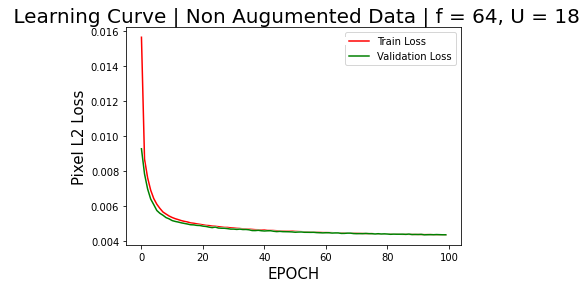

In [ ]:
plt.plot(trainloss5, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valloss5, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("Pixel L2 Loss", size = 15)
plt.title(" Learning Curve | Non Augumented Data | f = 64, U = 18", size = 20)
plt.savefig("rmodel5.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()

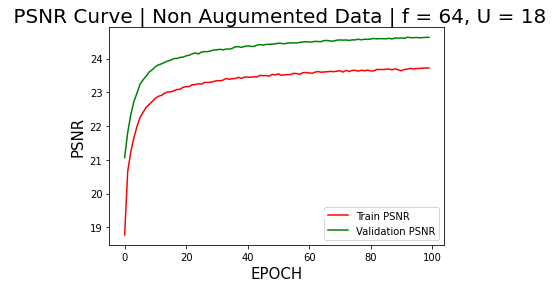

In [ ]:
plt.plot(trainPSNR5, c='red', path_effects=[pe.Stroke(linewidth=8, foreground='white'), pe.Normal()])
plt.plot(valPSNR5, c='green',path_effects=[pe.Stroke(linewidth=2, foreground='white'), pe.Normal()])
plt.legend(['Train PSNR','Validation PSNR'])
plt.xlabel("EPOCH", size=15)
plt.ylabel("PSNR", size = 15)
plt.title(" PSNR Curve | Non Augumented Data | f = 64, U = 18", size = 20)
plt.savefig("rmodel5PSNR.png", dpi=300,
        bbox_inches="tight"
       )
plt.show()